<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/_AA_Graduate_Project_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **Import libraries**

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time

import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn import ensemble, metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor

- **Import dataset**

In [69]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal=",").drop_duplicates()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


- **Memory reduction**

In [70]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 75.83 Mb (46.0% reduction)


- The problem at hand appears to have a misalignment between the frequency of the features and the desired output, which is the percentage of Silica Concentrate (% Silica Concentrate). It is important to note that individual records do not predict the average % Silica Concentrate. Instead, it is the cumulative effect of all parameters over a period of time that results in the averaged % Silica Concentrate.

- From an industrial perspective, it is proposed to group and average all the records based on the % Silica Concentrate in order to address this issue. This approach can be perceived as a shortcut, but it aligns with the industrial understanding of the problem and provides a more meaningful analysis. By consolidating the data in this manner, we can capture the combined impact of various parameters on the averaged % Silica Concentrate.

- **Data Preprocessing**

In [71]:
# Grouping and averaging values by % Silica Concentrate
flotation_grpby = flotation.groupby(['% Silica Concentrate']).mean()

# Extracting % Silica Concentrate values
y = flotation_grpby.index.values.tolist()

# Removing % Iron Concentrate column as it is highly correlated with % Silica Concentrate (0.8)
flotation_grpby = flotation_grpby.drop(columns='% Iron Concentrate')

# Feature Scaling
min_max_scaler = MinMaxScaler()
flotation_scaled = min_max_scaler.fit_transform(flotation_grpby.values)
flotation_scaled = pd.DataFrame(flotation_scaled, columns=flotation_grpby.columns)

- **Reducing dimensions is an effective approach to uncovering underlying variances.**

In [72]:
# Dimensions reduction with Principal Components Analysis
pca = PCA(n_components=10)
flotation_pca = pca.fit_transform(flotation_scaled)

# Creation of the different datasets for training and testing
X_train, X_test, y_train, y_test = train_test_split(flotation_pca, y, test_size=0.3, random_state=42)

- **Modelling**

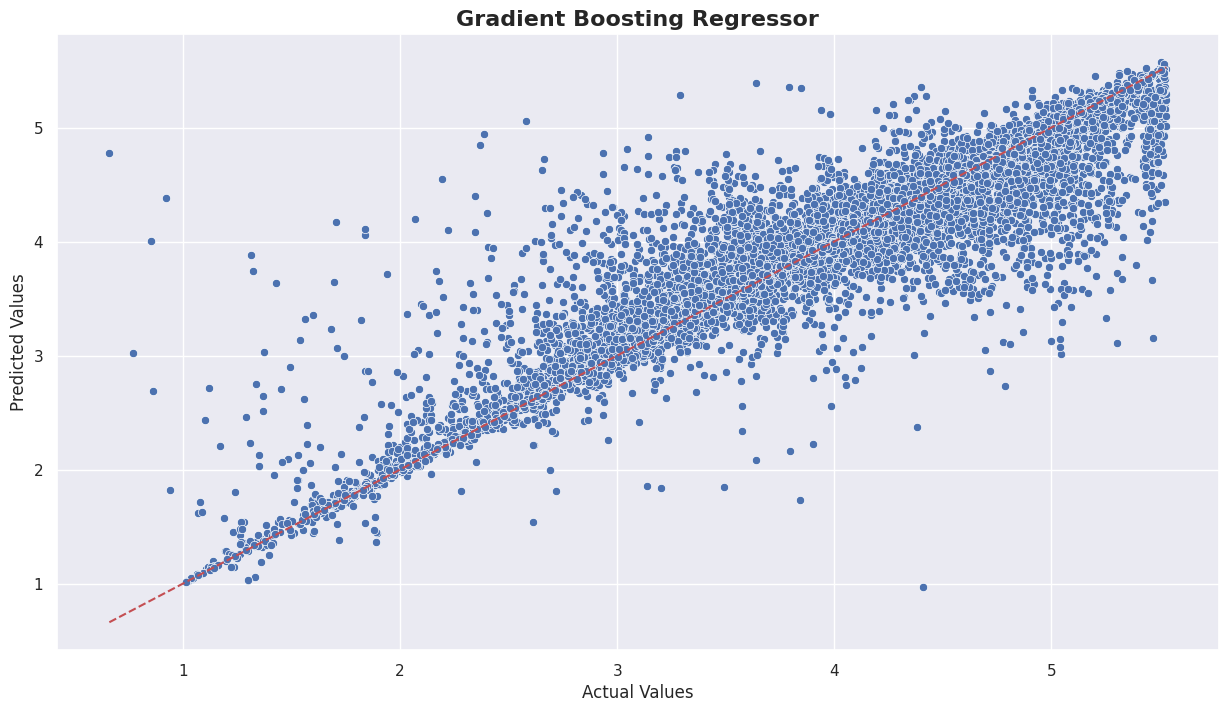

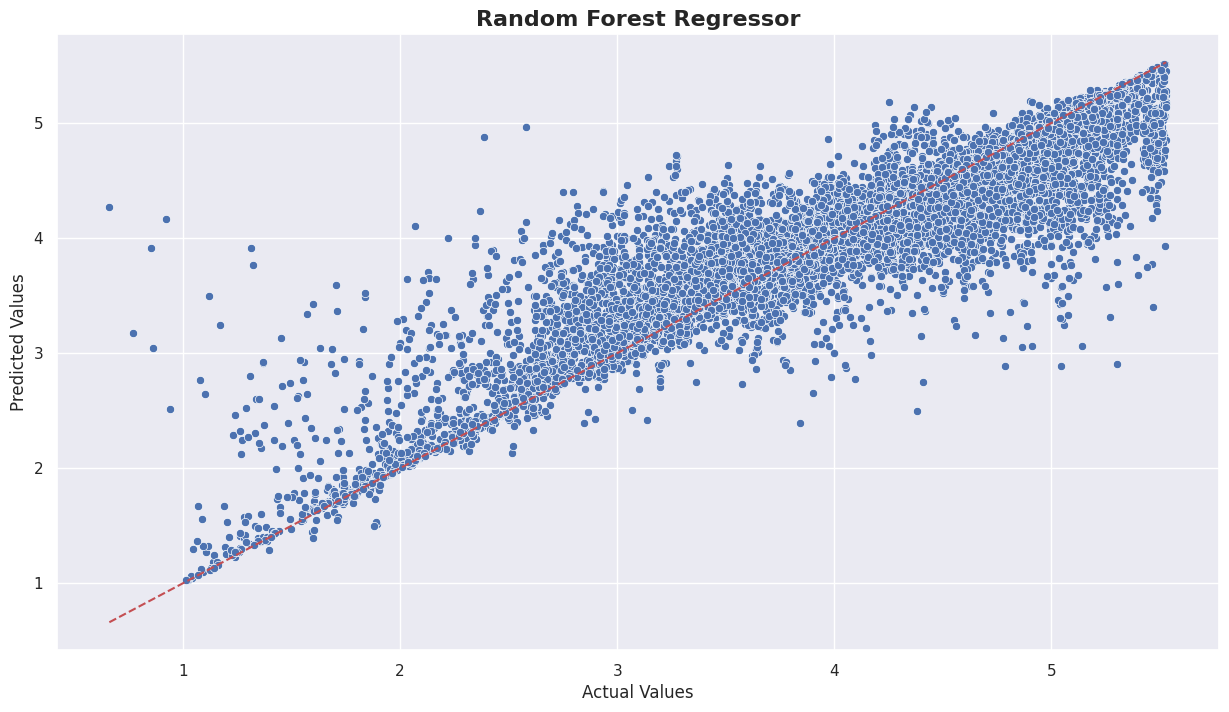

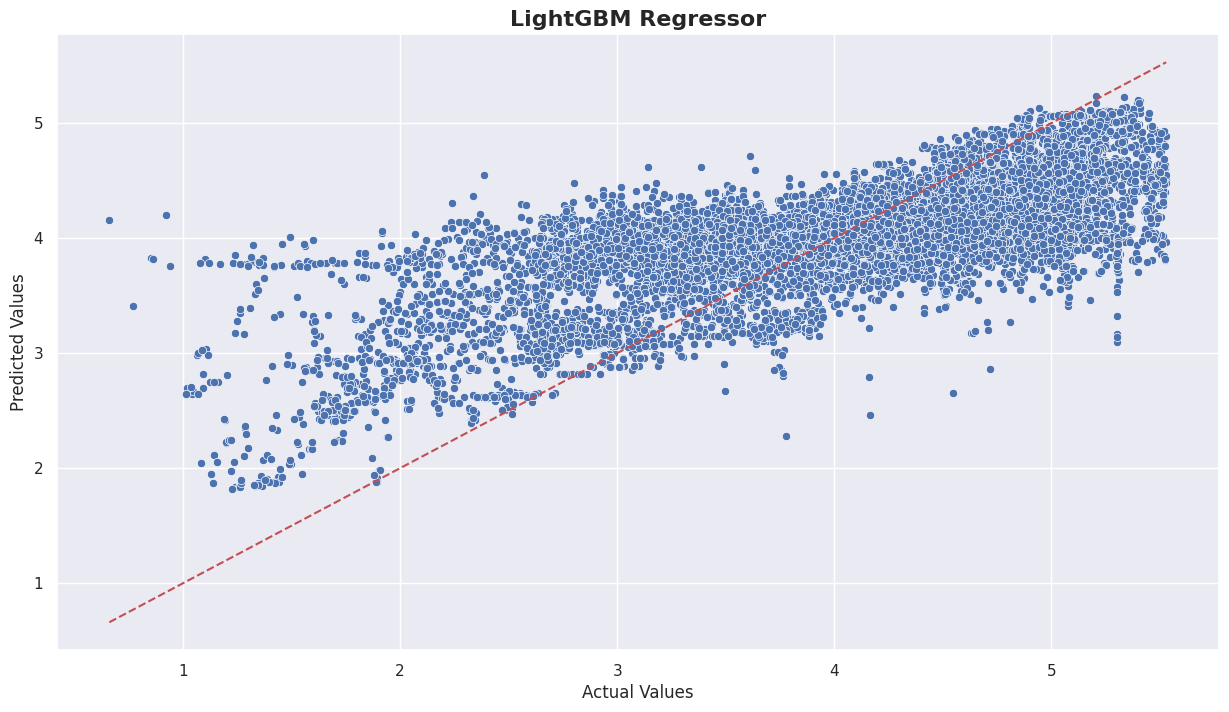

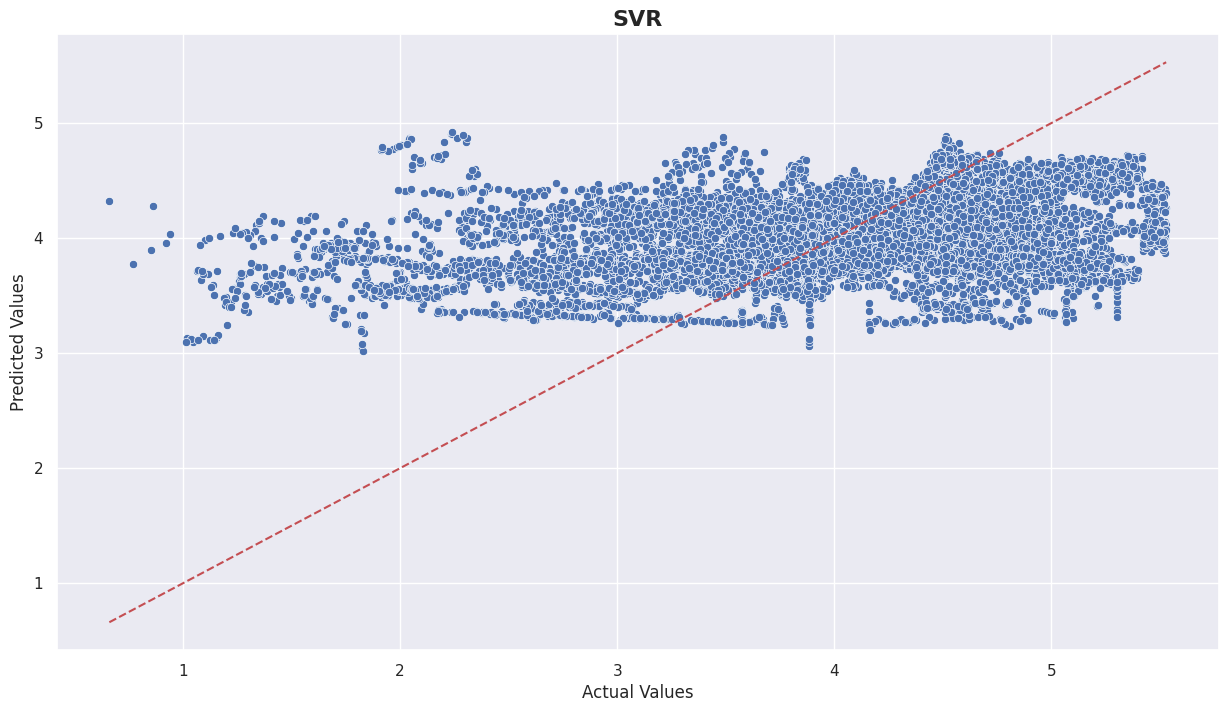

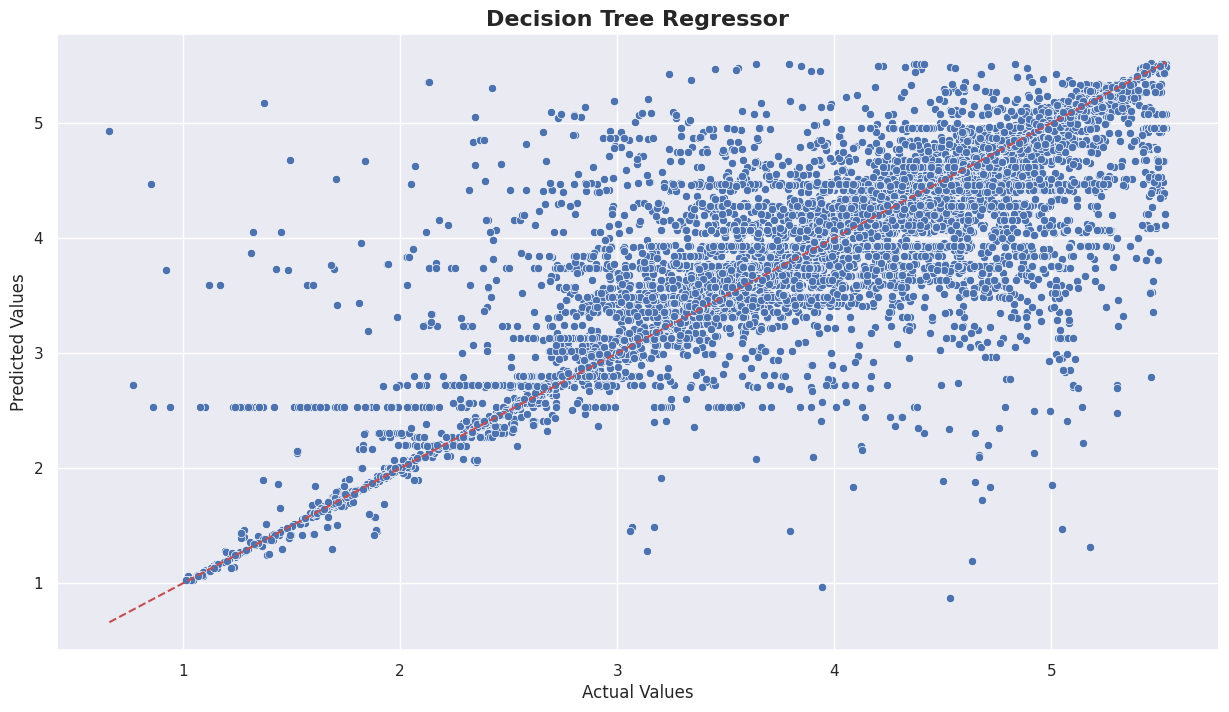

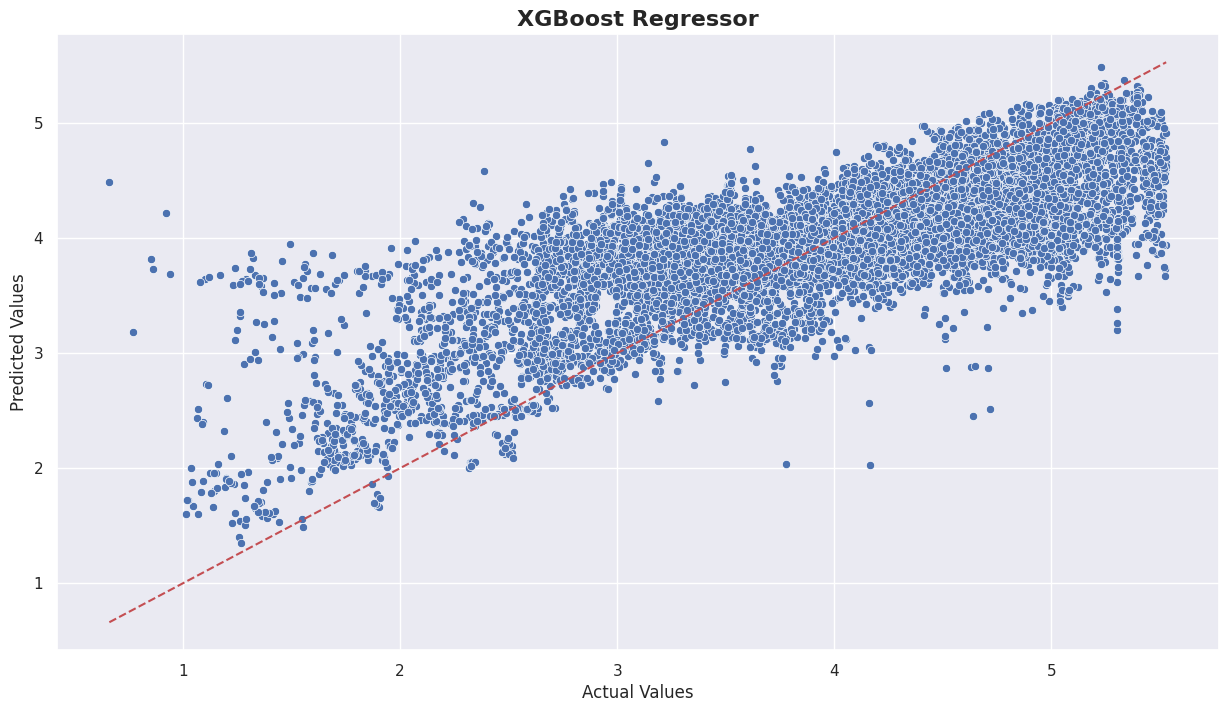

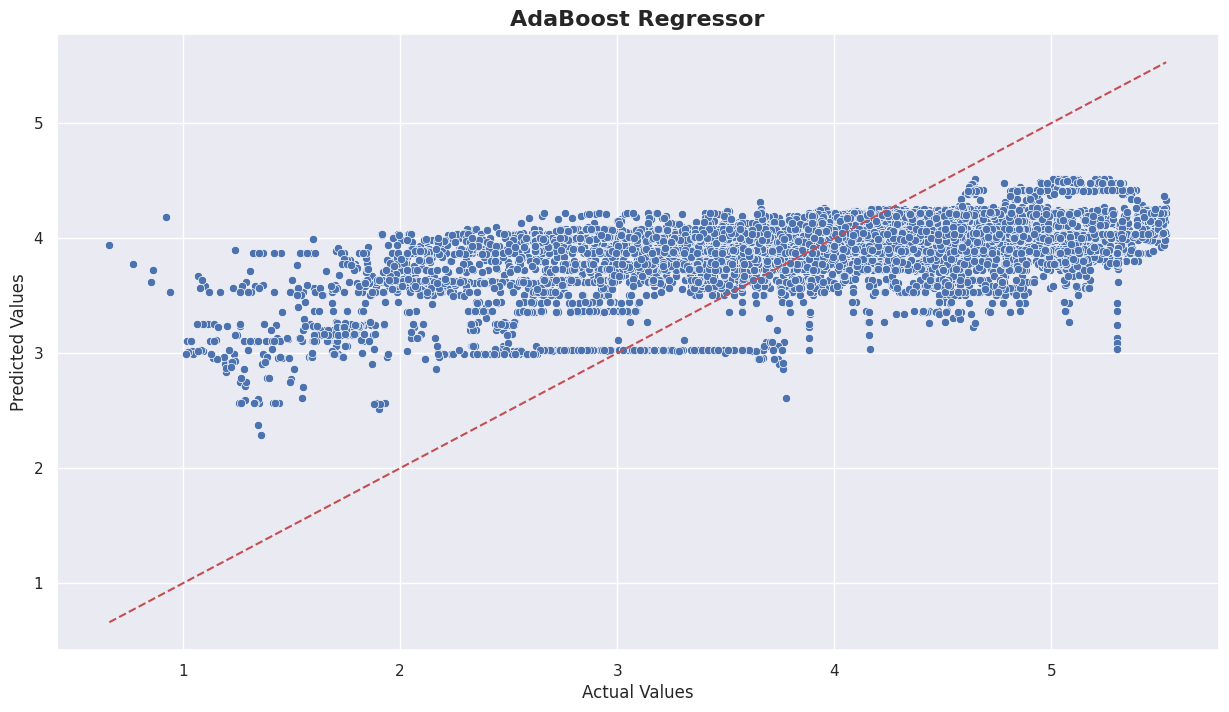

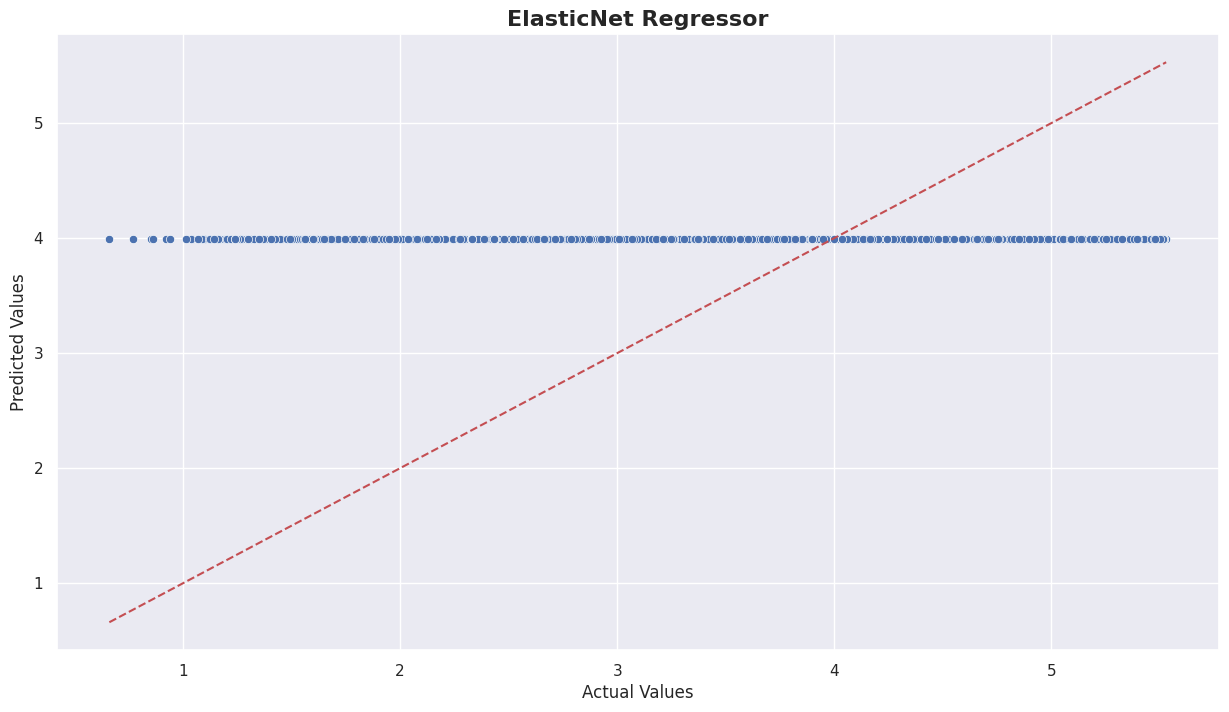

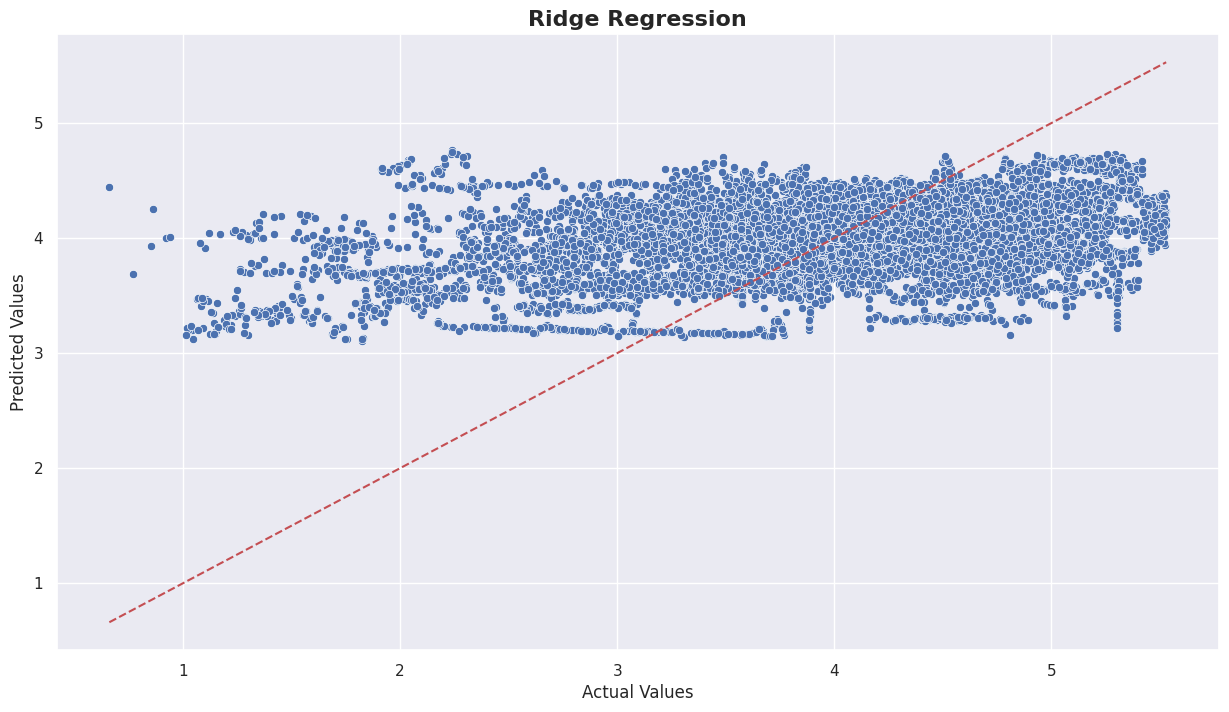

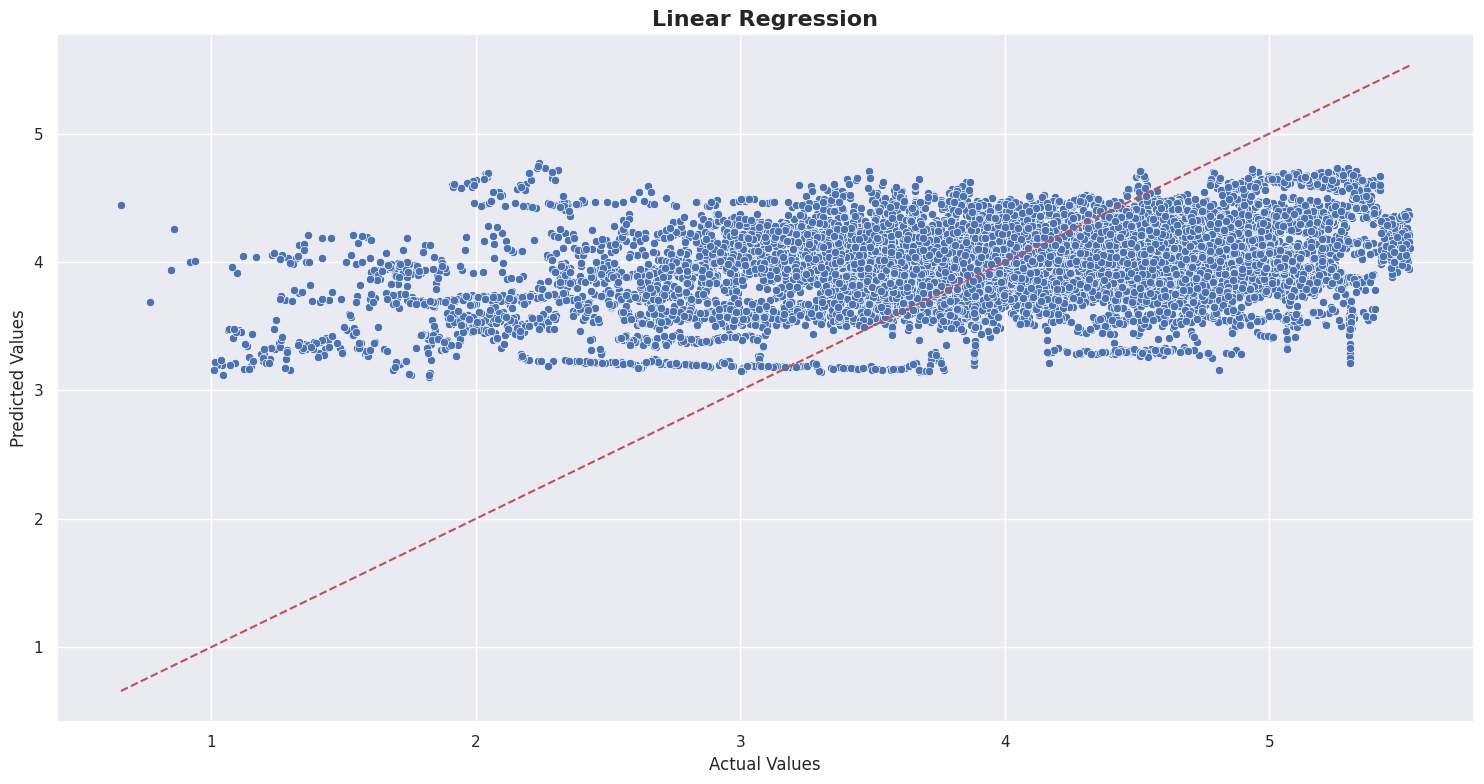

,Model,MSE (Test dataset),R-squared (Test dataset),Training Time,Inference Time
0,Gradient Boosting Regressor,0.087923,0.870261,116.286174,0.246870
1,Random Forest Regressor,0.106525,0.842812,64.926866,0.447489
4,Decision Tree Regressor,0.180670,0.733404,0.920055,0.003457
5,XGBoost Regressor,0.275022,0.594178,8.593638,0.021419
2,LightGBM Regressor,0.344839,0.491156,0.820069,0.059047
6,AdaBoost Regressor,0.547407,0.192246,20.347993,0.183027
8,Ridge Regression,0.602957,0.110276,0.021198,0.000540
9,Linear Regression,0.602959,0.110274,0.025494,0.001994
3,SVR,0.616458,0.090355,73.362134,19.760185
7,ElasticNet Regressor,0.677728,-0.000056,0.016459,0.000562


In [73]:
models = [
    {
        'name': 'Gradient Boosting Regressor',
        'model': ensemble.GradientBoostingRegressor(
            n_estimators=120,
            max_depth=16,
            learning_rate=0.1,
            criterion='squared_error'
        )
    },
    {
        'name': 'Random Forest Regressor',
        'model': RandomForestRegressor(
            n_estimators=120,
            max_depth=16,
            criterion='squared_error'
        )
    },
    {
        'name': 'LightGBM Regressor',
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.05
        )
    },
    {
        'name': 'SVR',
        'model': SVR(kernel='linear')
    },
    {
        'name': 'Decision Tree Regressor',
        'model': DecisionTreeRegressor(
            max_depth=16,
            criterion='poisson'
        )
    },
    {
        'name': 'XGBoost Regressor',
        'model': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1
        )
    },
    {
        'name': 'AdaBoost Regressor',
        'model': AdaBoostRegressor(
            n_estimators=120,
            learning_rate=0.1,
            loss='linear'
        )
    },
    {
        'name': 'ElasticNet Regressor',
        'model': ElasticNet(
            alpha=0.5,
            l1_ratio=0.5
        )
    },
    {
        'name': 'Ridge Regression',
        'model': Ridge(
            alpha=0.5,
            solver='auto'
        )
    },
    {
        'name': 'Linear Regression',
        'model': LinearRegression()
    }
]

# Lists to store metric values and execution times
model_names = []
r_squared_values = []
mse_values = []
execution_times = []

# Train and test the models
for model in models:
    model_name = model['name']
    model_instance = model['model']

    # Model training
    start_time = time.time()
    model_instance.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Model performance on test data
    start_time = time.time()
    y_pred = model_instance.predict(X_test)
    inference_time = time.time() - start_time

    # Calculate metrics
    r_squared = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)

    # Append metric values and execution times
    model_names.append(model_name)
    r_squared_values.append(r_squared)
    mse_values.append(mse)
    execution_times.append({
        'Training Time': training_time,
        'Inference Time': inference_time
    })

    # Plotting predicted vs. actual values
    plt.figure(figsize=(15, 8))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(model_name, fontsize=16, fontweight='bold')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

data = {
    'Model': model_names,
    'MSE (Test dataset)': mse_values,
    'R-squared (Test dataset)': r_squared_values,
    'Training Time': [t['Training Time'] for t in execution_times],
    'Inference Time': [t['Inference Time'] for t in execution_times]
}

metrics_df = pd.DataFrame(data)
sorted_df = metrics_df.sort_values(by='MSE (Test dataset)', ascending=True)
sorted_df

- **Plot Execution Times**

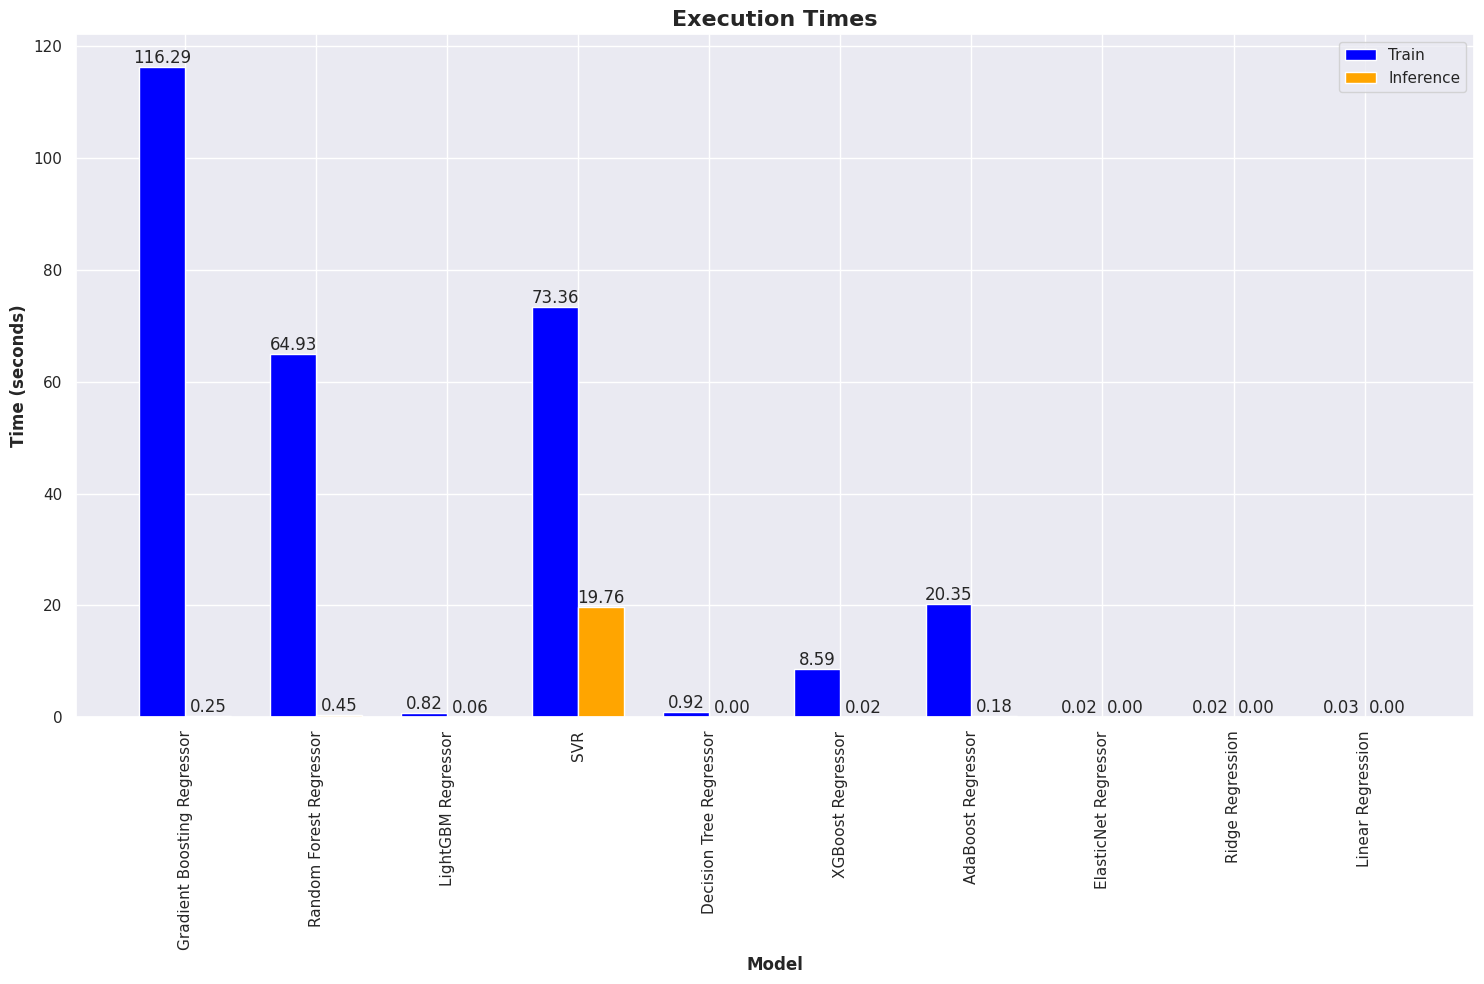

In [74]:
plt.figure(figsize=(15, 10))

execution_times_df = pd.DataFrame(execution_times, index=model_names)

bar_width = 0.35
index = range(len(model_names))

plt.bar(index, execution_times_df.iloc[:, 0], label='Train', color='blue', width=bar_width)
plt.bar([i + bar_width for i in index], execution_times_df.iloc[:, 1], label='Inference', color='orange', width=bar_width)

plt.title("Execution Times", fontsize=16, fontweight='bold')
plt.xlabel("Model", fontweight='bold')
plt.ylabel("Time (seconds)", fontweight='bold')
plt.xticks([i + bar_width/2 for i in index], model_names, rotation=90)
plt.legend()

# Add execution time labels
for i, row in enumerate(execution_times_df.iterrows()):
    model_name, execution_time = row
    plt.text(i, execution_time[0], f"{execution_time[0]:.2f}", ha='center', va='bottom')
    plt.text(i + bar_width, execution_time[1], f"{execution_time[1]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


- **Plot Models Performance**

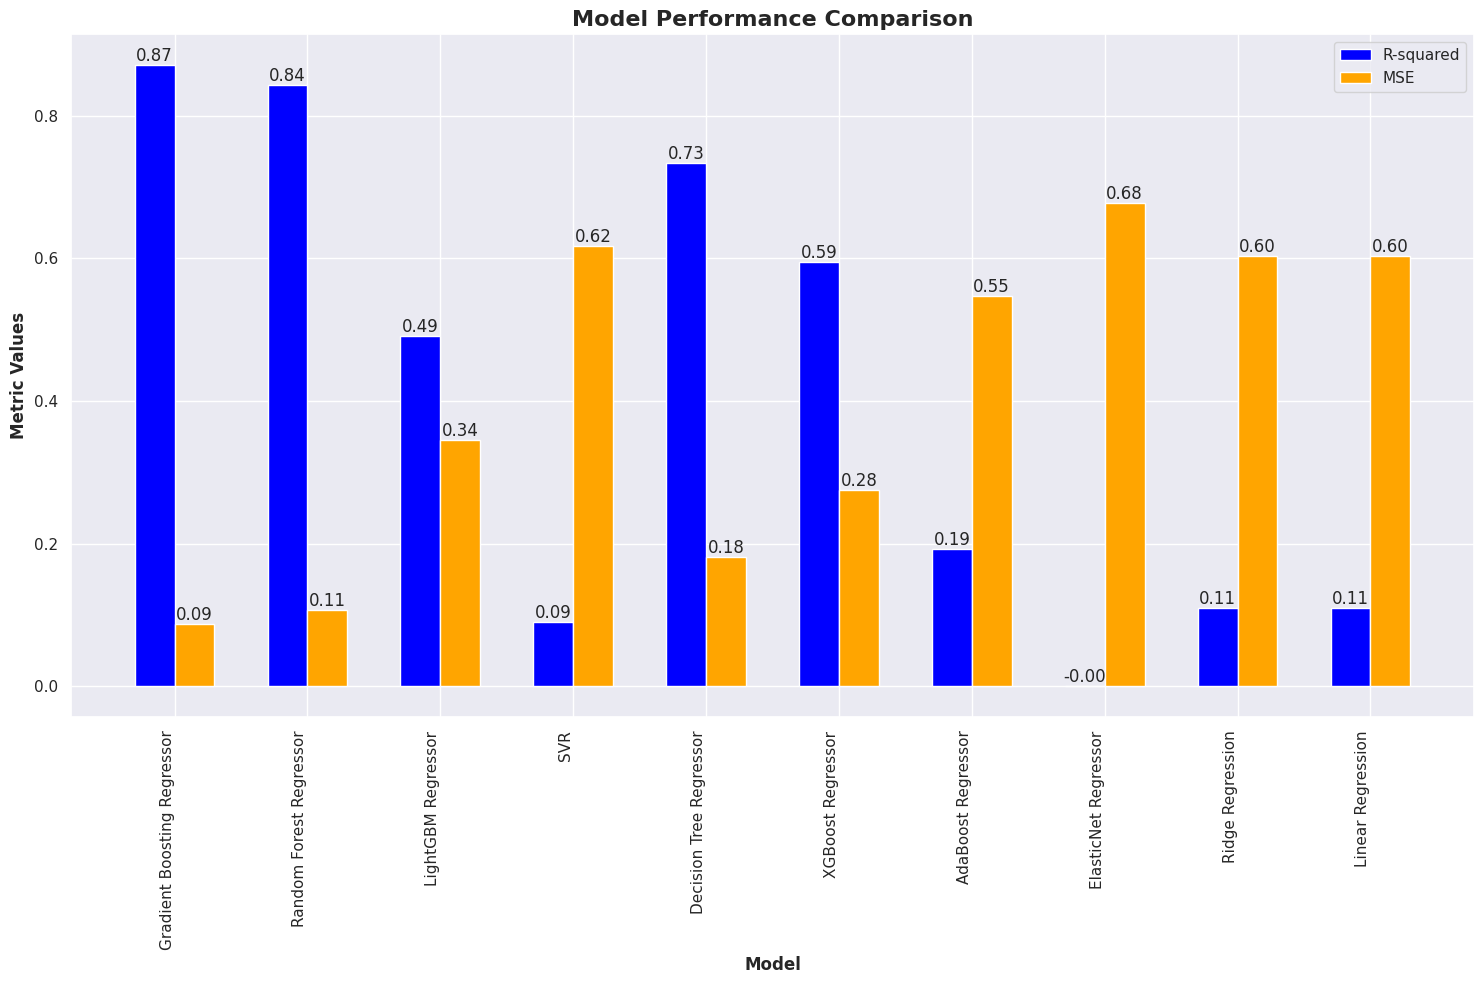

In [75]:
plt.figure(figsize=(15, 10))

bar_width = 0.30
index = np.arange(len(models))

plt.bar(index, r_squared_values, bar_width, label='R-squared', color='blue')
plt.bar(index + bar_width, mse_values, bar_width, label='MSE', color='orange')

for i, value in enumerate(r_squared_values):
    plt.text(i, value, f"{value:.2f}", ha='center', va='bottom')

for i, value in enumerate(mse_values):
    plt.text(i + bar_width, value, f"{value:.2f}", ha='center', va='bottom')

plt.xlabel("Model", fontweight='bold')
plt.ylabel("Metric Values", fontweight='bold')
plt.title("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.xticks(index + bar_width / 2, model_names, rotation=90, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

- **Conclussion**

Based on the updated results obtained from the different regression models after sorting them in ascending order based on the "MSE (Test dataset)" column, we can draw the following conclusions:

1. Gradient Boosting Regressor: The Gradient Boosting Regressor continues to outperform other models with the lowest MSE of 0.0879 and a high R-squared value of 0.8703. It has a longer training time of 116.29 seconds but a fast inference time of 0.2469 seconds.

2. Random Forest Regressor: The Random Forest Regressor remains the second-best performer, with an MSE of 0.1065 and an R-squared value of 0.8428. It has a shorter training time compared to the Gradient Boosting Regressor (64.93 seconds) but a slightly longer inference time (0.4475 seconds).

3. Decision Tree Regressor: The Decision Tree Regressor shows decent performance, with an MSE of 0.1807 and an R-squared value of 0.7334. It has a very short training time of 0.92 seconds and an extremely low inference time of 0.0035 seconds.

4. XGBoost Regressor: The XGBoost Regressor exhibits moderate performance, with an MSE of 0.2750 and an R-squared value of 0.5942. It has a longer training time compared to some models (8.59 seconds) but a fast inference time of 0.0214 seconds.

5. LightGBM Regressor: The LightGBM Regressor performs relatively well, with an MSE of 0.3448 and an R-squared value of 0.4912. It has a very short training time of 0.82 seconds and a moderate inference time of 0.0590 seconds.

6. AdaBoost Regressor: The AdaBoost Regressor shows relatively poor performance, with an MSE of 0.5474 and an R-squared value of 0.1922. It has a moderate training time of 20.35 seconds and an inference time of 0.1830 seconds.

7. Ridge Regression: The Ridge Regression model performs poorly, with an MSE of 0.6029 and an R-squared value of 0.1103. It has a short training time (0.0212 seconds) and a very low inference time (0.0005 seconds).

8. Linear Regression: The Linear Regression model exhibits similar results to the Ridge Regression model, with an MSE of 0.6029 and an R-squared value of 0.1103. It has similar training and inference times as the Ridge Regression model.

9. SVR: The Support Vector Regressor (SVR) performs poorly, with an MSE of 0.6165 and an R-squared value of 0.0904. It has a long training time of 73.36 seconds and a relatively high inference time of 19.76 seconds.

10. ElasticNet Regressor: The ElasticNet Regressor demonstrates very weak performance, with an MSE of 0.6777 and an almost zero R-squared value (-0.000056). It has a very short training time (0.0165 seconds) and a relatively higher inference time (0.0006 seconds).

In conclusion, considering the MSE metric as the primary criterion, the Gradient Boosting Regressor and Random Forest Regressor remain the top-performing models. The Decision Tree Regressor also shows a good balance between performance and efficiency.